In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set dataset directory path
dataset_path = '/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/dataset/augmented_updated'


Mounted at /content/drive


In [2]:
# Enhanced Dataset Preprocessing with More Augmentations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(299, 299),  # InceptionV3 input size
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 1600 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [3]:
# Load Pre-Trained InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
# Build Custom Layers on Top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = BatchNormalization()(x)  # Added Batch Normalization
x = Dropout(0.5)(x)          # Dropout to reduce overfitting
x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
x = Dropout(0.3)(x)          # Additional Dropout for regularization
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [5]:
# Freeze Base Model Layers
for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Compile the Model with a Warm-Up Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),  # Start with a high learning rate for warm-up
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [7]:
# Callbacks for Training
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7, verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=5, restore_best_weights=True, verbose=1
    )
]

In [8]:
# Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,  # Fewer epochs for warm-up
    callbacks=callbacks
)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 416s 7s/step - accuracy: 0.4480 - loss: 20.1452 - val_accuracy: 0.4650 - val_loss: 14.7806 - learning_rate: 0.0010
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6528 - loss: 13.1357 - val_accuracy: 0.5250 - val_loss: 10.1897 - learning_rate: 0.0010
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.6476 - loss: 9.1095 - val_accuracy: 0.5525 - val_loss: 7.4109 - learning_rate: 0.0010
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 998ms/step - accuracy: 0.6958 - loss: 6.6047 - val_accuracy: 0.5325 - val_loss: 5.7134 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.6876 - loss: 4.9895 - val_accuracy: 0.5375 - val_loss: 4.5798 - learning_rate: 0.0010
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7144 - loss: 3.8591 - val_accuracy: 0.5450 - val_loss: 3.7433 - learning_rate: 0.0010
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 81s 996ms/step - accuracy: 0.7323 - loss: 3.0868 - val_accuracy:

In [9]:
# Fine-Tune the Model
# Gradually Unfreeze Layers for Fine-Tuning
for layer in base_model.layers[:249]:
    layer.trainable = False
for layer in base_model.layers[249:]:
    layer.trainable = True

# Recompile with a Lower Learning Rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the Fine-Tuned Model
fine_tune_history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.7224 - loss: 1.1531 - val_accuracy: 0.6775 - val_loss: 1.1840 - learning_rate: 1.0000e-05
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step - accuracy: 0.7572 - loss: 1.0120 - val_accuracy: 0.6950 - val_loss: 1.1256 - learning_rate: 1.0000e-05
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8093 - loss: 0.9208 - val_accuracy: 0.6975 - val_loss: 1.1242 - learning_rate: 1.0000e-05
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8023 - loss: 0.8937 - val_accuracy: 0.6950 - val_loss: 1.0997 - learning_rate: 1.0000e-05
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.8266 - loss: 0.8275 - val_accuracy: 0.7250 - val_loss: 1.0321 - learning_rate: 1.0000e-05
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8442 - loss: 0.7829 - val_accuracy: 0.7350 - val_loss: 1.0222 - learning_rate: 1.0000e-05
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.8527 - loss:

In [10]:
# Save the Model
model.save('/content/drive/MyDrive/Colab Notebooks/Cholesteatoma/inceptionv3(1).h5')

In [11]:
# Combine Histories for Visualization
history.history['accuracy'].extend(fine_tune_history.history['accuracy'])
history.history['val_accuracy'].extend(fine_tune_history.history['val_accuracy'])
history.history['loss'].extend(fine_tune_history.history['loss'])
history.history['val_loss'].extend(fine_tune_history.history['val_loss'])

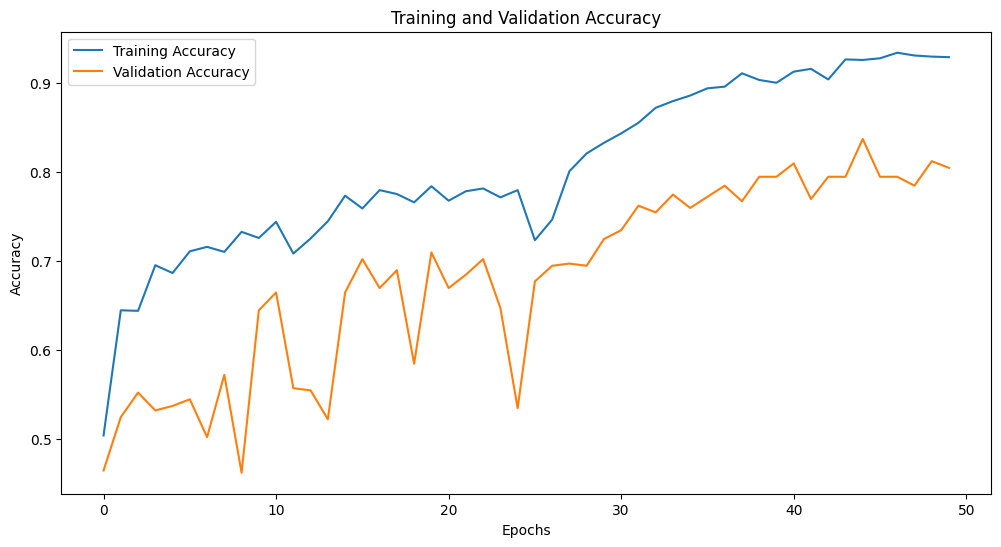

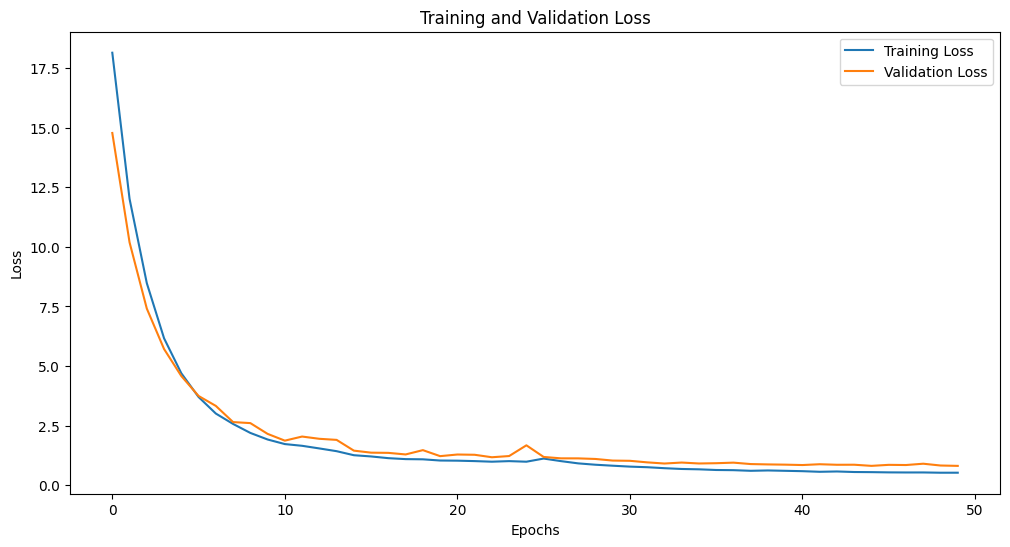

In [12]:
# Plot Accuracy
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()